In [ ]:
import os
os.chdir("/content/drive/My Drive/ds_shriyanksingh")

!pwd

/content/drive/My Drive/ds_shriyanksingh


FSI coverage: 2018-02-01 → 2025-05-02


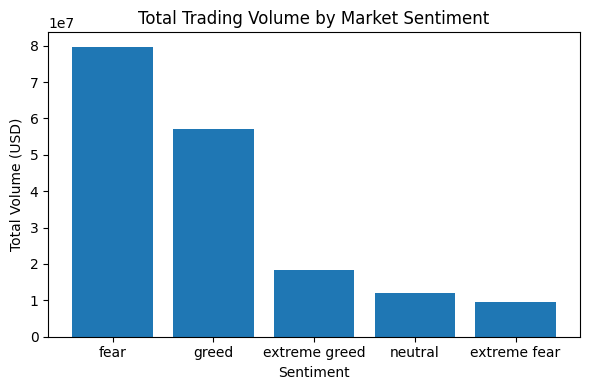

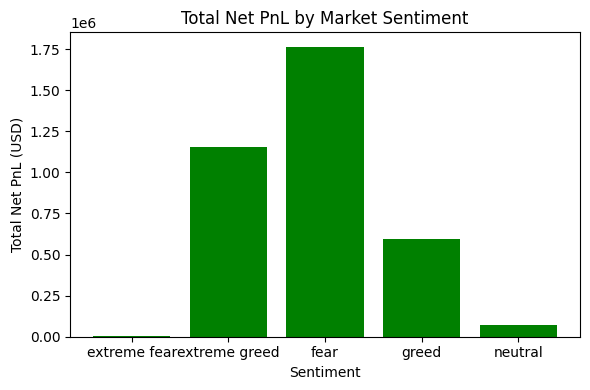

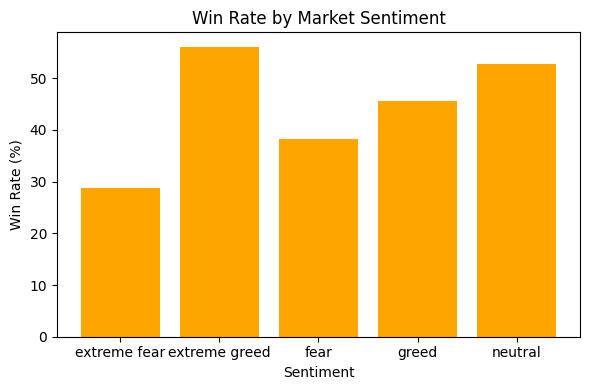

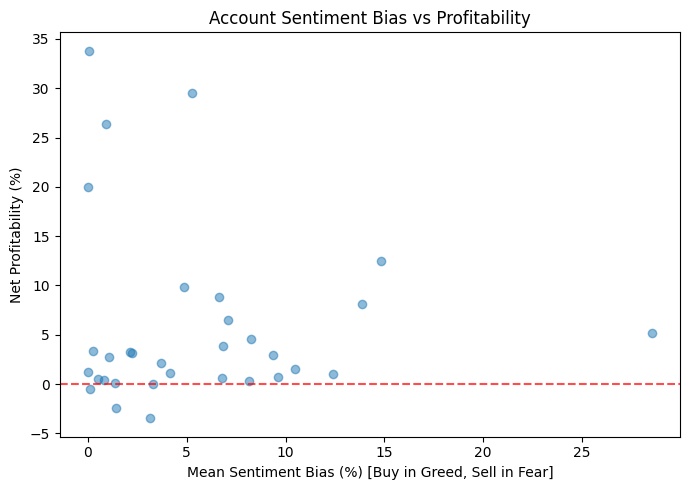

In [1]:
#Importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Loading the datasets (load only neccessary columns )
col = ["Account", "Execution Price", "Size Tokens",
            "Size USD", "Side", "Timestamp IST", "Closed PnL", "Fee", "Trade ID"]
hd=pd.read_csv('/content/drive/My Drive/ds_shriyanksingh/historical_data.csv',usecols=col,low_memory=False)
fsi=pd.read_csv('/content/drive/My Drive/ds_shriyanksingh/fear_greed_index.csv',usecols=['classification','date','timestamp'])

#Data Cleaning & normalising strings
for x in ["Execution Price", "Size Tokens", "Size USD", "Closed PnL", "Fee"]:
    hd[x] = pd.to_numeric(hd[x], errors="coerce")
for x in ["Side", "Direction"]:
    if x in hd.columns:
        hd[x] = hd[x].astype(str).str.lower().str.strip()
fsi["classification"] = fsi["classification"].astype(str).str.lower().str.strip()

#Parsing Timestamps to datatime and create a Date column
if 'Timestamp IST' in hd.columns:
    hd['Date'] = pd.to_datetime(hd['Timestamp IST'], errors='coerce')
elif 'Timestamp' in hd.columns:
    hd['Date'] = pd.to_datetime(hd['Timestamp'], errors='coerce', unit='s', utc=True).dt.tz_convert(None)
hd['Date']=hd['Date'].dt.normalize()
if 'Date' in fsi.columns:
    fsi['Date'] = pd.to_datetime(fsi['date'], errors='coerce').dt.normalize()
elif 'timestamp' in fsi.columns:
    fsi['Date'] = pd.to_datetime(fsi['timestamp'], errors='coerce', unit='s', utc=True).dt.tz_convert(None)
fsi['Date']=fsi['Date'].dt.normalize()

# Keep only needed columns and drop bad rows
fsi = fsi.dropna(subset=['Date', 'classification']).copy()

# Aggregate to daily level (pick the mode classification)
fsi_daily = (
    fsi.groupby('Date', as_index=False)['classification']
       .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
)

# Fill missing days by forward filling of sentiment column
fsi_daily = fsi_daily.sort_values('Date')
fgi_idx = pd.date_range(fsi_daily['Date'].min(), fsi_daily['Date'].max(), freq='D')
fsi_daily = (
    fsi_daily.set_index('Date')
             .reindex(fgi_idx)
             .ffill()
             .rename_axis('Date')
             .reset_index()
)
print("FSI coverage:", fsi_daily['Date'].min().date(), "→", fsi_daily['Date'].max().date())



#Merging needed columns of fsi to hd
merged=hd.merge(fsi_daily,on='Date',how='left')

#Feature selection
merged['Net Pnl']=merged['Closed PnL']-merged['Fee']
merged['Is Profit']=merged['Net Pnl']>0
merged['Returns(%)']=merged['Net Pnl']/merged['Size USD']

#Grouping and aggregating
grouped = (merged
  .groupby("classification", observed=True)
  .agg(trades         = ("Trade ID","count"),
       total_vol_usd  = ("Size USD","sum"),
       avg_size_usd   = ("Size USD","mean"),
       avg_exec_price = ("Execution Price","mean"),
       avg_net_pnl    = ("Net Pnl","mean"),
       total_net_pnl  = ("Net Pnl","sum"),
       win_rate       = ("Is Profit","mean"))
  .reset_index())


#Data Visualization
import matplotlib.pyplot as plt
# total volume by sentiment
plot_df = grouped.sort_values('total_vol_usd', ascending=False)
plt.figure(figsize=(6,4))
plt.bar(plot_df['classification'], plot_df['total_vol_usd'])
plt.xlabel('Sentiment')
plt.ylabel('Total Volume (USD)')
plt.title('Total Trading Volume by Market Sentiment')
plt.tight_layout()
plt.show()

#Total Net PnL by Sentiment
plt.figure(figsize=(6,4))
plt.bar(grouped["classification"], grouped["total_net_pnl"], color='green')
plt.xlabel("Sentiment")
plt.ylabel("Total Net PnL (USD)")
plt.title("Total Net PnL by Market Sentiment")
plt.tight_layout()
plt.show()

# Win Rate by Sentiment
plt.figure(figsize=(6,4))
plt.bar(grouped["classification"], grouped["win_rate"]*100,color='orange')
plt.xlabel("Sentiment")
plt.ylabel("Win Rate (%)")
plt.title("Win Rate by Market Sentiment")
plt.tight_layout()
plt.show()


# Account Sentiment bias vs profitability(to check the profitabilty of those who buy and sell motivated by sentiments)
merged["is_buy_greed"] = (merged["Side"]=="buy") & (merged["classification"]=="greed")
merged["is_sell_fear"] = (merged["Side"]=="sell") & (merged["classification"]=="fear")

#Grouping and aggregating based on Account
grouped1 = (
        merged.groupby("Account",observed=True)
        .agg(
            total_trades=("Account","count"),
            total_usd=("Size USD","sum"),
            total_net_pnl=("Net Pnl","sum"),
            buys=("Side", lambda s: (s=="buy").sum()),
            sells=("Side", lambda s: (s=="sell").sum()),
            holding= ("Size Tokens", lambda x: x[x.index.isin(merged[merged["Side"]=="sell"].index)].sum() / x.sum()), # Corrected lambda function
            greed_buys=("is_buy_greed","sum"),
            fear_sells=("is_sell_fear","sum")
        )
        .reset_index()
    )


# Calculate metrics
grouped1["buy_greed_pct"] = grouped1["greed_buys"] / grouped1["buys"].replace(0,np.nan)
grouped1["sell_fear_pct"] = grouped1["fear_sells"] / grouped1["sells"].replace(0,np.nan)
grouped1["sentiment_bias"] = (grouped1["buy_greed_pct"].fillna(0) + grouped1["sell_fear_pct"].fillna(0)) / 2
grouped1["profitability_pct"] = grouped1["total_net_pnl"] / (grouped1["total_usd"].replace(0,np.nan)*grouped1["holding"])
#Plot
plt.figure(figsize=(7,5))
plt.scatter(grouped1["sentiment_bias"]*100, grouped1["profitability_pct"]*100, alpha=0.5)
plt.xlabel("Mean Sentiment Bias (%) [Buy in Greed, Sell in Fear]")
plt.ylabel("Net Profitability (%)")
plt.title("Account Sentiment Bias vs Profitability")
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

FGI coverage: 2018-02-01 → 2025-05-02

Final Sentiment Summary:
   classification  trades  total_vol_usd  total_net_pnl  win_trades  \
0   extreme fear    2326     9580240.04   2.803185e+03         667   
1  extreme greed    5621    18223760.27   1.152196e+06        3152   
2           fear   13869    79674391.06   1.763533e+06        5316   
3          greed   11292    57045815.74   5.972910e+05        5159   
4        neutral    2756    11939551.21   7.211464e+04        1453   

   avg_size_usd  avg_net_pnl  win_rate  
0   4118.761840     1.205153  0.286758  
1   3242.085086   204.980551  0.560754  
2   5744.782685   127.156430  0.383301  
3   5051.878829    52.895056  0.456872  
4   4332.202906    26.166414  0.527213  


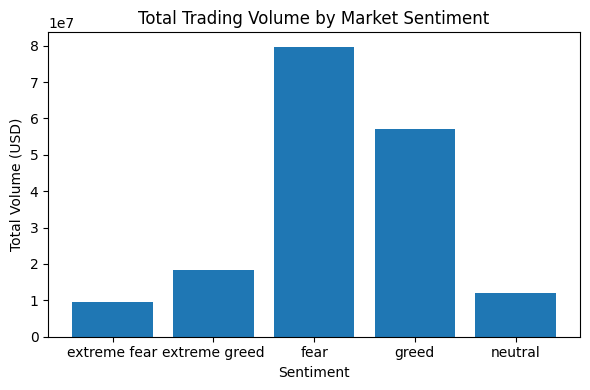

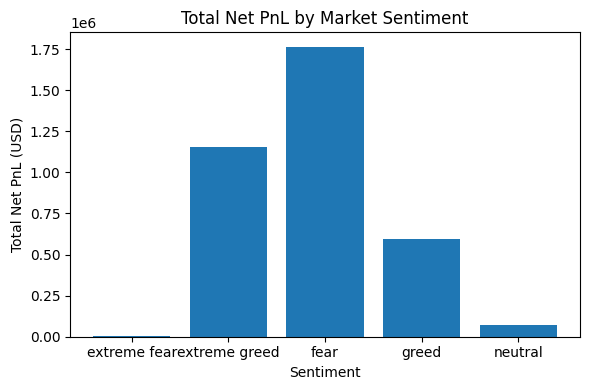

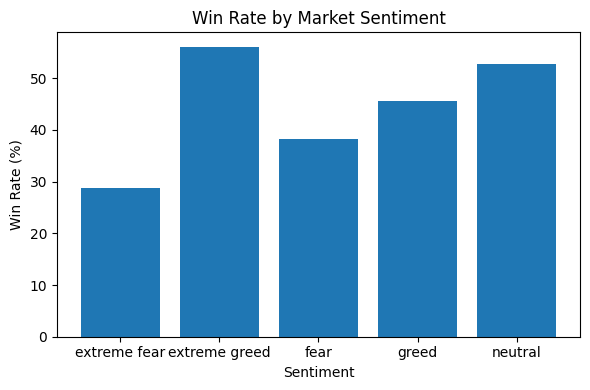

KeyError: 'Closed Pnl'

In [ ]:
# ===============================================
# Import Libraries
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ===============================================
# File Paths
# ===============================================
HIST_PATH = '/content/drive/My Drive/ds_shriyanksingh/historical_data.csv'
FGI_PATH  = '/content/drive/My Drive/ds_shriyanksingh/fear_greed_index.csv'

# Columns we actually need from the large trade file
cols_to_use = [
    "Account", "Coin", "Execution Price", "Size Tokens",
    "Size USD", "Side", "Timestamp IST", "Timestamp",
    "Closed PnL", "Fee"
]

# Chunk size for processing large CSVs
CHUNKSIZE = 500_000

# ===============================================
# Load Fear & Greed Index (small file, safe to load fully)
# ===============================================
fgi_raw = pd.read_csv(FGI_PATH, low_memory=False)

# Normalize column names
fgi_raw.columns = [c.strip().lower() for c in fgi_raw.columns]

# Use 'Date' column if available, otherwise parse 'timestamp'
if 'Date' in fgi_raw.columns:
    fgi_raw['Date'] = pd.to_Datetime(fgi_raw['Date'], errors='coerce').dt.normalize()
elif 'timestamp' in fgi_raw.columns:
    fgi_raw['timestamp'] = pd.to_Datetime(fgi_raw['timestamp'], errors='coerce', unit='s', utc=True).dt.tz_convert(None)
    fgi_raw['Date'] = fgi_raw['timestamp'].dt.normalize()

# Clean classification column
fgi_raw['classification'] = fgi_raw['classification'].astype(str).str.lower().str.strip()

# Keep only needed columns and drop bad rows
fgi = fgi_raw.dropna(subset=['Date', 'classification']).copy()

# Aggregate to daily level (pick the mode classification)
fsi_daily = (
    fgi.groupby('Date', as_index=False)['classification']
       .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
)

# Fill missing days by forward filling
fsi_daily = fsi_daily.sort_values('Date')
fgi_idx = pd.Date_range(fsi_daily['Date'].min(), fsi_daily['Date'].max(), freq='D')
fsi_daily = (
    fsi_daily.set_index('Date')
             .reindex(fgi_idx)
             .ffill()
             .rename_axis('Date')
             .reset_index()
)

print("FGI coverage:", fsi_daily['Date'].min().Date(), "→", fsi_daily['Date'].max().Date())

# ===============================================
# Process Historical Data in Chunks
# ===============================================
chunk_results = []

for chunk in pd.read_csv(HIST_PATH, usecols=cols_to_use, chunksize=CHUNKSIZE, low_memory=False):

    # Convert numerics
    for col in ["Execution Price", "Size Tokens", "Size USD", "Closed PnL", "Fee"]:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors="coerce")


    # Clean side text
    if "Side" in chunk.columns:
        chunk["Side"] = chunk["Side"].astype(str).str.lower().str.strip()

    # Parse timestamp (prefer IST if available)
    if "Timestamp IST" in chunk.columns:
        ts = pd.to_Datetime(chunk["Timestamp IST"], errors="coerce")
    else:
        ts = pd.to_Datetime(chunk["Timestamp"], errors="coerce", unit='s', utc=True).dt.tz_convert(None)

    chunk["Date"] = ts.dt.normalize()

    # Drop rows missing critical fields
    chunk = chunk.dropna(subset=["Date", "Closed PnL", "Fee"])

    if chunk.empty:
        continue

    # Merge with daily FGI
    merged = chunk.merge(fsi_daily, on="Date", how="left")

    # Feature Engineering
    merged["Net Pnl"] = merged["Closed PnL"].fillna(0) - merged["Fee"].fillna(0)
    merged["Is Profit"] = (merged["Net Pnl"] > 0).astype(int)

    # Chunk-level aggregation
    grouped = (
        merged.groupby("classification", observed=True)
        .agg(
            trades=("Account", "size"), # Use size to count rows in each group
            total_vol_usd=("Size USD", "sum"),
            total_net_pnl=("Net Pnl", "sum"),
            win_trades=("Is Profit", "sum")
        )
        .reset_index()
    )
    chunk_results.append(grouped)

# Combine results from all chunks
final = pd.concat(chunk_results, ignore_index=True)

# Final aggregation across all data
grouped = (
    final.groupby("classification", observed=True)
         .agg(
             trades=("trades", "sum"),
             total_vol_usd=("total_vol_usd", "sum"),
             total_net_pnl=("total_net_pnl", "sum"),
             win_trades=("win_trades", "sum")
         )
         .reset_index()
)

# Derived metrics
grouped["avg_size_usd"] = grouped["total_vol_usd"] / grouped["trades"]
grouped["avg_net_pnl"]  = grouped["total_net_pnl"] / grouped["trades"]
grouped["win_rate"]     = grouped["win_trades"] / grouped["trades"]

print("\nFinal Sentiment Summary:\n", grouped)

# ===============================================
# Create 'outputs' folder
# ===============================================
os.makedirs("outputs", exist_ok=True)

# ===============================================
# Visualization 1: Total Volume by Sentiment
# ===============================================
plt.figure(figsize=(6,4))
plt.bar(grouped["classification"], grouped["total_vol_usd"])
plt.xlabel("Sentiment")
plt.ylabel("Total Volume (USD)")
plt.title("Total Trading Volume by Market Sentiment")
plt.tight_layout()
plt.savefig("outputs/total_volume_by_sentiment.png")
plt.show()

# ===============================================
# Visualization 2: Total Net PnL by Sentiment
# ===============================================
plt.figure(figsize=(6,4))
plt.bar(grouped["classification"], grouped["total_net_pnl"])
plt.xlabel("Sentiment")
plt.ylabel("Total Net PnL (USD)")
plt.title("Total Net PnL by Market Sentiment")
plt.tight_layout()
plt.savefig("outputs/net_pnl_by_sentiment.png")
plt.show()

# ===============================================
# Visualization 3: Win Rate by Sentiment
# ===============================================
plt.figure(figsize=(6,4))
plt.bar(grouped["classification"], grouped["win_rate"]*100)
plt.xlabel("Sentiment")
plt.ylabel("Win Rate (%)")
plt.title("Win Rate by Market Sentiment")
plt.tight_layout()
plt.savefig("outputs/win_rate_by_sentiment.png")
plt.show()

# ===============================================
# Visualization 4: Daily Net PnL vs FGI
# ===============================================
# Aggregate daily net pnl
daily_results = []
daily_cols_to_use = ["Timestamp IST","Timestamp","Closed PnL","Fee"] # Define columns for daily PnL aggregation
for chunk in pd.read_csv(HIST_PATH, usecols=daily_cols_to_use, chunksize=CHUNKSIZE):
    ts = pd.to_Datetime(chunk.get("Timestamp IST", chunk.get("Timestamp")), errors="coerce", unit='s', utc=True).dt.tz_convert(None)
    chunk["Date"] = ts.dt.normalize()
    chunk["net_pnl"] = pd.to_numeric(chunk["Closed Pnl"], errors="coerce").fillna(0) - pd.to_numeric(chunk["Fee"], errors="coerce").fillna(0)
    daily = chunk.groupby("Date")["net_pnl"].sum()
    daily_results.append(daily)

daily_pnl = pd.concat(daily_results).groupby("Date").sum().reset_index()
daily_pnl = daily_pnl.merge(fsi_daily, on="Date", how="left")

plt.figure(figsize=(10,4))
plt.plot(daily_pnl["Date"], daily_pnl["net_pnl"], label="Daily Net Pnl")
plt.xlabel("Date")
plt.ylabel("Daily Net Pnl")
plt.title("Daily Net PnL vs Market Sentiment")
plt.tight_layout()
plt.savefig("outputs/daily_netpnl.png")
plt.show()

# ===============================================
# Visualization 5: Boxplot of Net PnL by Sentiment (Sampled)
# ===============================================
sample_cols_to_use = ["Closed Pnl","Fee","Timestamp IST","Timestamp"] # Define columns for sampling
sample = pd.read_csv(HIST_PATH, usecols=sample_cols_to_use, nrows=20000)
sample["net_pnl"] = pd.to_numeric(sample["Closed Pnl"], errors='coerce').fillna(0) - pd.to_numeric(sample["Fee"], errors='coerce').fillna(0)
ts = pd.to_Datetime(sample.get("Timestamp IST", sample.get("Timestamp")), errors="coerce", unit='s', utc=True).dt.tz_convert(None)
sample["Date"] = ts.dt.normalize()

sample = sample.dropna(subset=["Date", "net_pnl"])
sample = sample.merge(fsi_daily, on="Date", how="left")

plt.figure(figsize=(6,4))
sample.boxplot(column="net_pnl", by="classification")
plt.ylabel("Net Pnl")
plt.title("Distribution of Net Pnl by Sentiment (Sampled 20k trades)")
plt.suptitle("")
plt.tight_layout()
plt.savefig("outputs/boxplot_netpnl_sentiment.png")
plt.show()

# ===============================================
# Visualization 6: Top 5 Coins Volume by Sentiment
# ===============================================
coin_results = []
coin_cols_to_use = ["Coin","Size USD","Timestamp IST","Timestamp"] # Define columns for coin volume
for chunk in pd.read_csv(HIST_PATH, usecols=coin_cols_to_use, chunksize=CHUNKSIZE):
    ts = pd.to_Datetime(chunk.get("Timestamp IST", chunk.get("Timestamp")), errors="coerce", unit='s', utc=True).dt.tz_convert(None)
    chunk["Date"] = ts.dt.normalize()
    merged = chunk.merge(fsi_daily, on="Date", how="left")
    grouped = merged.groupby(["classification","Coin"], observed=True)["Size USD"].sum().reset_index()
    coin_results.append(grouped)

coin_df = pd.concat(coin_results).groupby(["classification","Coin"])["Size USD"].sum().reset_index()
top_coins = coin_df.groupby("Coin")["Size USD"].sum().nlargest(5).index
plot_df = coin_df[coin_df["Coin"].isin(top_coins)]

plt.figure(figsize=(8,5))
for cls in plot_df["classification"].unique():
    sub = plot_df[plot_df["classification"]==cls]
    plt.bar(sub["Coin"], sub["Size USD"], alpha=0.6, label=cls)
plt.legend(title="Sentiment")
plt.ylabel("Total Volume (USD)")
plt.title("Top 5 Coins – Volume by Sentiment")
plt.tight_layout()
plt.savefig("outputs/top5_coins_volume_sentiment.png")
plt.show()